<h2>Trends in Logged Hours Between May 2019-May 2020</h2>

<h3>Background</h3>

This one is fairly simple. In my current work as a consultant/data analyst, I log my hours for my various projects. I was especially curious to see <b>how COVID-19 has impacted my workload as measured by logged hours.</b> To answer this question, I downloaded all of my time entries between May 2019 and May 2020 and created the figures below.

<h3>Data Cleaning</h3>

As always, the first step is changing our working directory and importing the data.

cd /Users/colinsorensen/Desktop/datapractice/Time_Entries

In [1]:
import pandas as pd
from pandas.tseries.offsets import BDay
from matplotlib.dates import DateFormatter
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

In [2]:
#Read CSV
entries = pd.read_csv("time_entries.csv")

This next cell creates a new column that codes each record (which are logged in 15 minute increments) as 'Billable', 'Non-Billable', 'PTO', or 'Holiday.' After that, each date must be converted to a datetime data type (since they imported as strings).

In [3]:
#Create new column that summarizes each records as 'Billable', 'Non-Billable', 'PTO', or 'Holiday.'
entries.loc[entries['Project'].str.contains('Homebase|HOMEBASE'),'billable'] = 'nonbillable'
entries.loc[entries['Task/Deliverable'].str.contains('Holiday'),'billable'] = 'holiday'
entries.loc[entries['Task/Deliverable'].str.contains('Vacation|Sick'),'billable'] = 'PTO'
entries.loc[(entries['Task/Deliverable'].str.contains('Peer Communities'))|(entries.billable.isna()),'billable'] = 'billable'
entries.loc[entries.billable.isna()]['billable'] = 'billable'

In [4]:
#Convert date to datetime variable & set as index
entries['Date'] = pd.to_datetime(entries['Date'])
entries.set_index('Date',inplace=True)

The next few cells create three dataframes. The first dataframe, 'unsmoothed', summarizes total hours by business day. The second dataframe, 'smoothed', uses 'unsmoothed' to create a 1-month rolling average. Finally, 'breakdown' creates a summary of hours by function (billable, nonbillable, etc.) and week from the new column created in the first step.

In [5]:
#Create resampled series that sums all hours logged per business day
unsmoothed = entries['Time in Hours'].resample('B').sum()

#Create rolling average for each 2-week period
smoothed = unsmoothed.rolling(window=20).mean()

unsmoothed.head()

Date
2019-05-27     8.0
2019-05-28     9.5
2019-05-29     9.5
2019-05-30     8.0
2019-05-31    10.5
Freq: B, Name: Time in Hours, dtype: float64

In [6]:
#Break hours down by billable/nonbillable/vacation, etc.
breakdown = entries.groupby('billable')['Time in Hours'].resample('W',label='left').sum().unstack('billable').fillna(0)
breakdown = breakdown[['billable', 'nonbillable', 'PTO', 'holiday']]

breakdown.head()

billable,billable,nonbillable,PTO,holiday
Date,,,,
2019-05-26,28.00,9.00,0.0,8.5
2019-06-02,37.50,3.25,0.0,0.0
2019-06-09,44.50,1.00,0.0,0.0
2019-06-16,44.00,8.75,0.0,0.0
2019-06-23,37.25,4.25,0.0,0.0


<h3>Analysis</h3>

It's time to make a figure! This figure is a two row subplot consisting of multiple axes, derived from each of the three dataframes created above.

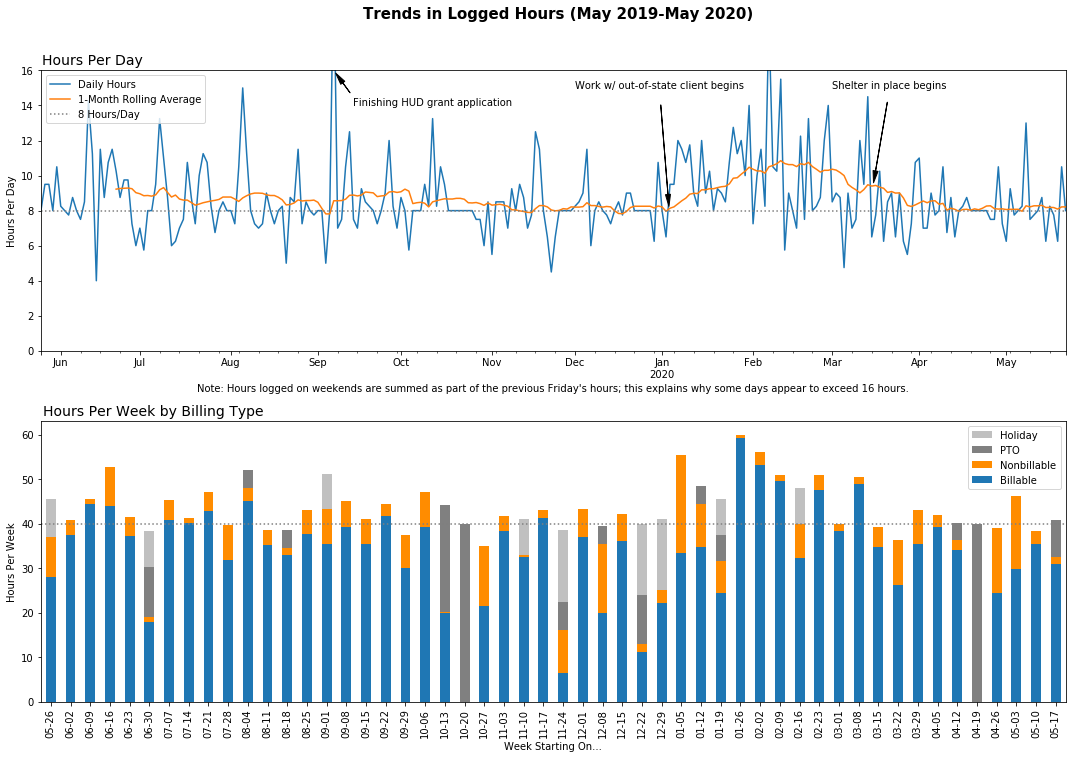

In [17]:
#Plot billable/nonbillable hours as stacked bar chart
fig = plt.figure(figsize=(15,10))
fig.suptitle("Trends in Logged Hours (May 2019-May 2020)", fontsize=15, fontweight="bold",y=1.05,x=.52)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

#Plot unsmoothed and smoothed line graphs
unsmoothed.plot(kind='line',legend=True,ylim=[0,16],ax=ax1)
smoothed.plot(kind='line',legend=True,ax=ax1)
ax1.axhline(y=8, color='tab:gray', linestyle=':')
ax1.set_title('Hours Per Day',size=14,x=.05)
ax1.set_xlabel('''Note: Hours logged on weekends are summed as part of the previous Friday's hours; this explains why some days appear to exceed 16 hours.''',
          )
ax1.set_ylabel('Hours Per Day')
ax1.annotate('Finishing HUD grant application',
             xy=('2019-09-06',16),
             xytext=('2019-09-13', 14),
             arrowprops=dict(facecolor='black', 
                             shrink=0.1, 
                             width=.05,
                             headwidth=5))
ax1.annotate('Work w/ out-of-state client begins',
             xy=('2020-01-03',7.5),
             xytext=('2019-12-01', 15),
             arrowprops=dict(facecolor='black', 
                             shrink=0.1, 
                             width=.05,
                             headwidth=5))
ax1.annotate('Shelter in place begins',
             xy=('2020-03-16',9),
             xytext=('2020-03-01', 15),
             arrowprops=dict(facecolor='black', 
                             shrink=0.1, 
                             width=.05,
                             headwidth=5))
ax1.legend(["Daily Hours","1-Month Rolling Average","8 Hours/Day"],loc='upper left')

#Plot billable
breakdown.plot(kind='bar',stacked=True,color=['tab:blue','darkorange','gray','silver'],ax=ax2)
ax2.axhline(y=40, color='tab:gray', linestyle=':')
ax2.set_title("Hours Per Week by Billing Type",size=14,x=.11)
labels=['Billable','Nonbillable','PTO','Holiday']
ax2.set_xlabel('Week Starting On...')
ax2.set_ylabel('Hours Per Week')
plt.gca().xaxis.set_major_formatter(plt.FixedFormatter(breakdown.index.to_series().dt.strftime("%m-%d")))
ax2.legend(reversed(plt.legend().legendHandles), reversed(labels))

plt.tight_layout()

Overall, it appears that COVID-19 had <i>some</i> impact on my total workload, but it was not the sole driver since my hours had already been decreasing prior to Mayor Breed's shelter-in-place order. More likely, this reduction was a result of travel and on-site visits being moved to remote status at the start of March (including those meetings with my out-of-state client).

The second figure has fewer obvious insights, other than that most of my hours are billable, and they generally meet or exceed the 40-hour threshold per week. For those who prefer numbers to figures, see the breakdown below.

In [8]:
print(entries.groupby('billable')['Time in Hours'].sum().sort_values(ascending=False))
print("")
print("Total")
print(entries.groupby('billable')['Time in Hours'].sum().sum())

billable
billable       1735.75
nonbillable     277.00
PTO             167.00
holiday          96.50
Name: Time in Hours, dtype: float64

Total
2276.25


Over the year-long period between May 2019 and May 2020, I logged 1,735.75 billable hours, 277 nonbillable hours, 167 hours of PTO, and 96.5 hours of holiday. This equates to 2,276.25 totals hours, or nearly 10% more than the available working hours in a year (2,080 hours = 52 weeks x 40 hours).

In [9]:
pd.pivot_table(index='billable',values='Time in Minutes',aggfunc=sum,data=entries,margins=True)/(52*40*60)

,Time in Minutes
billable,
PTO,0.080288
billable,0.834495
holiday,0.046394
nonbillable,0.133173
All,1.094351


In addition, my billable hour utilization rate was 83%, which exceeded the firm's expectation of 75%.